# Recommendation List Bayesian Analysis

This notebook analyzes the results of Bayesian inference for the recommendation lists.

## Setup

In [1]:
model = 'full'

In [2]:
import sys
from pathlib import Path
from textwrap import dedent

In [3]:
import pandas as pd
import numpy as np
import tables
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels as sm
import statsmodels.nonparametric.api as smnp

from scipy import stats
from scipy.special import expit, logit, logsumexp
from IPython.display import display, Markdown

In [4]:
import bookgender.datatools as dt

## Load Data

In [5]:
datasets = list(dt.datasets.keys())

Load the profile and list data for context:

In [6]:
profiles = pd.read_pickle('data/profile-data.pkl')
rec_lists = pd.read_pickle('data/rec-data.pkl')
rec_lists.head()

ambiguous  female  male  unknown  Total  Known  \
Set Algorithm user                                                    
AZ  als       34891          0       6     8       36     50     14   
              35841          0       3     1       46     50      4   
              39018          0       1    14       35     50     15   
              52563          0       8    12       30     50     20   
              60825          1      13     8       28     50     21   

                     PropKnown  PropFemale  dcknown  dcyes    PropDC  
Set Algorithm user                                                    
AZ  als       34891       0.28    0.428571       10      5  0.500000  
              35841       0.08    0.750000        3      1  0.333333  
              39018       0.30    0.066667        9      3  0.333333  
              52563       0.40    0.400000       14      5  0.357143  
              60825       0.42    0.619048       13      9  0.692308

In [7]:
if model.endswith('-dcode'):
    rec_lists['Bias'] = (rec_lists['dcyes']) / (rec_lists['dcknown'])
    profiles['ProfileBias'] = profiles['PropDC']
else:
    rec_lists['Bias'] = (rec_lists['female']) / (rec_lists['Known'])
    profiles['ProfileBias'] = profiles['PropFemale']

In [8]:
rec_lists.groupby('Set')['Total'].count()

Set
AZ      6903
BX-E    1966
BX-I    3994
GR-E    1977
GR-I    4000
Name: Total, dtype: int64

Let's load the samples!

In [9]:
sample_files = {}
for ds in datasets:
    sample_files[ds] = tables.File(f'data/{ds}/{model}-samples.h5', 'r')
    sfile = Path('data') / ds / f'{model}-model.txt'
    text = sfile.read_text()
    display(Markdown(f'''
### Fit results for {ds}

```
{text}
```'''))


### Fit results for AZ

```
Inference for Stan model: full_785981cbf6c68ac4d34f72b93488aa54.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu       -0.54  8.2e-4   0.06  -0.65  -0.58  -0.54   -0.5  -0.43   4714    1.0
sigma     1.59  1.4e-3   0.05    1.5   1.56   1.59   1.62   1.69   1334    1.0
nMean     7.82  3.5e-3   0.39    7.1   7.55    7.8   8.07   8.62  12026    1.0
nDisp     0.43  1.8e-4   0.02   0.39   0.42   0.43   0.45   0.47  13052    1.0
recB[1]  -0.41  2.1e-4   0.02  -0.46  -0.43  -0.41   -0.4  -0.37   9153    1.0
recB[2]  -0.11  6.8e-4   0.04  -0.19  -0.14  -0.11  -0.08  -0.03   3522    1.0
recB[3]  -0.34  3.8e-4   0.03   -0.4  -0.36  -0.34  -0.31  -0.28   6243    1.0
recB[4]  -0.22  5.9e-4   0.04   -0.3  -0.25  -0.22   -0.2  -0.15   4218    1.0
recB[5]  -0.48  3.3e-4   0.03  -0.53  -0.49  -0.48  -0.46  -0.43   6164    1.0
recB[6]  -0.05  6.0e-4   0.03   -0.1  -0.07  -0.05  -0.03   0.01   2450    1.0
recB[7]  -0.04  7.4e-4   0.04  -0.11  -0.07  -0.04  -0.02   0.03   2339    1.0
recS[1]    0.1  1.5e-4   0.01   0.08   0.09    0.1   0.11   0.13   6799    1.0
recS[2]   0.77  7.0e-4   0.03   0.72   0.75   0.77   0.79   0.82   1528    1.0
recS[3]   0.42  3.7e-4   0.02   0.38    0.4   0.42   0.43   0.46   2823    1.0
recS[4]   0.68  6.0e-4   0.03   0.63   0.67   0.68    0.7   0.73   1785    1.0
recS[5]   0.34  3.1e-4   0.02   0.31   0.33   0.34   0.35   0.37   2891    1.0
recS[6]   0.79  6.7e-4   0.02   0.74   0.77   0.79    0.8   0.83   1060    1.0
recS[7]   0.96  8.3e-4   0.03   0.91   0.94   0.96   0.98   1.01    976    1.0
recV[1]    0.6  1.2e-4   0.01   0.58   0.59    0.6   0.61   0.63  12343    1.0
recV[2]   1.03  2.6e-4   0.03   0.98   1.01   1.03   1.04   1.08   9491    1.0
recV[3]   0.85  1.9e-4   0.02   0.81   0.84   0.85   0.86   0.89  10730    1.0
recV[4]    1.0  2.6e-4   0.02   0.96   0.99    1.0   1.02   1.05   9226    1.0
recV[5]    0.7  1.7e-4   0.02   0.66   0.68    0.7   0.71   0.73  10532    1.0
recV[6]   0.62  2.6e-4   0.02   0.58    0.6   0.62   0.63   0.65   5029    1.0
recV[7]   0.71  3.4e-4   0.02   0.67    0.7   0.71   0.73   0.76   4601    1.0

Samples were drawn using NUTS at Sat Aug 17 03:37:23 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
```


### Fit results for BX-E

```
Inference for Stan model: full_785981cbf6c68ac4d34f72b93488aa54.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu       -0.42  4.8e-4   0.04   -0.5  -0.45  -0.42  -0.39  -0.33   8151    1.0
sigma     1.17  8.3e-4   0.04   1.08   1.14   1.16   1.19   1.25   2629    1.0
nMean    14.97  6.1e-3   0.74  13.59  14.46  14.95  15.47  16.49  14985    1.0
nDisp     0.43  1.5e-4   0.02   0.39   0.41   0.43   0.44   0.46  15247    1.0
recB[1]  -0.22  1.8e-4   0.02  -0.25  -0.23  -0.22   -0.2  -0.18  10368    1.0
recB[2]  -0.31  2.0e-4   0.02  -0.35  -0.32  -0.31  -0.29  -0.27  10000    1.0
recS[1]   0.15  2.3e-4   0.02   0.12   0.14   0.15   0.16   0.18   5612    1.0
recS[2]   0.26  3.0e-4   0.02   0.23   0.25   0.26   0.28    0.3   4130    1.0
recV[1]   0.52  1.1e-4   0.01   0.49   0.51   0.52   0.52   0.54  12156    1.0
recV[2]   0.54  1.4e-4   0.01   0.51   0.53   0.54   0.54   0.56   9192    1.0

Samples were drawn using NUTS at Sat Aug 17 03:34:44 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
```


### Fit results for BX-I

```
Inference for Stan model: full_785981cbf6c68ac4d34f72b93488aa54.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu       -0.39  4.8e-4   0.04  -0.46  -0.42  -0.39  -0.37  -0.32   6015    1.0
sigma     1.04  8.3e-4   0.03   0.98   1.02   1.04   1.06    1.1   1540   1.01
nMean    32.57    0.01   1.75  29.33   31.4  32.49  33.68  36.21  16276    1.0
nDisp     0.35  1.2e-4   0.01   0.32   0.34   0.35   0.35   0.37  14310    1.0
recB[1]   0.18  5.8e-4   0.03   0.12   0.16   0.18    0.2   0.24   2854    1.0
recB[2]    0.1  3.6e-4   0.03   0.05   0.08    0.1   0.12   0.15   5310    1.0
recB[3]  -0.24  3.0e-4   0.02  -0.29  -0.26  -0.24  -0.23   -0.2   4928    1.0
recB[4]  -0.11  3.6e-4   0.02  -0.15  -0.12  -0.11   -0.1  -0.07   2933    1.0
recS[1]   1.28  1.1e-3   0.04   1.21   1.25   1.28    1.3   1.35   1062   1.01
recS[2]   0.68  5.5e-4   0.03   0.63   0.66   0.68    0.7   0.73   2370    1.0
recS[3]   0.56  4.6e-4   0.02   0.52   0.55   0.56   0.58   0.61   2208    1.0
recS[4]   0.78  5.8e-4   0.02   0.74   0.77   0.78   0.79   0.82   1336   1.01
recV[1]   0.64  3.5e-4   0.02   0.59   0.62   0.64   0.65   0.68   3858    1.0
recV[2]   0.69  1.6e-4   0.02   0.66   0.68   0.69    0.7   0.72  11501    1.0
recV[3]   0.55  1.3e-4   0.01   0.52   0.54   0.55   0.56   0.57  11148    1.0
recV[4]   0.42  1.9e-4   0.01   0.39   0.41   0.42   0.43   0.44   5057    1.0

Samples were drawn using NUTS at Sat Aug 17 03:33:01 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
```


### Fit results for GR-E

```
Inference for Stan model: full_785981cbf6c68ac4d34f72b93488aa54.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu       -0.25  4.1e-4   0.05  -0.35  -0.28  -0.25  -0.22  -0.15  14857    1.0
sigma     1.52  4.9e-4   0.04   1.44   1.49   1.52   1.55    1.6   7040    1.0
nMean    86.13    0.03   3.36  79.79  83.82  86.03  88.33  92.96  14572    1.0
nDisp     0.68  2.2e-4   0.03   0.63   0.66   0.68   0.69   0.73  13974    1.0
recB[1]  -0.32  2.6e-4   0.03  -0.38  -0.34  -0.32   -0.3  -0.26  12909    1.0
recB[2]   -0.5  1.8e-4   0.02  -0.54  -0.52   -0.5  -0.49  -0.46  13529    1.0
recS[1]   0.45  2.1e-4   0.02   0.41   0.43   0.45   0.46   0.49   9525    1.0
recS[2]   0.26  1.5e-4   0.01   0.23   0.25   0.26   0.27   0.29   9644    1.0
recV[1]   0.89  2.0e-4   0.02   0.85   0.88   0.89   0.91   0.94  11776    1.0
recV[2]   0.62  1.3e-4   0.01   0.59   0.61   0.62   0.63   0.65  12687    1.0

Samples were drawn using NUTS at Sat Aug 17 03:46:50 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
```


### Fit results for GR-I

```
Inference for Stan model: full_785981cbf6c68ac4d34f72b93488aa54.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu       -0.27  3.6e-4   0.04  -0.35  -0.29  -0.27  -0.24  -0.18  14376    1.0
sigma     1.33  3.5e-4   0.03   1.27   1.31   1.33   1.35    1.4   8755    1.0
nMean    140.0    0.04    5.5 129.55 136.23 139.85 143.57 151.38  15668    1.0
nDisp     0.66  2.1e-4   0.03   0.61   0.64   0.66   0.67   0.71  14806    1.0
recB[1]  -0.02  2.5e-4   0.03  -0.07  -0.04  -0.02-4.4e-4   0.03  11547    1.0
recB[2]   0.18  2.2e-4   0.03   0.13   0.16   0.18    0.2   0.23  12957    1.0
recB[3]  -0.11  2.2e-4   0.03  -0.16  -0.13  -0.11  -0.09  -0.06  12638    1.0
recB[4]  -0.05  2.1e-4   0.02  -0.09  -0.06  -0.05  -0.04  -0.01   9174    1.0
recS[1]   1.08  2.5e-4   0.02   1.04   1.07   1.08    1.1   1.12   7527    1.0
recS[2]   0.74  1.9e-4   0.02    0.7   0.72   0.74   0.75   0.77   9830    1.0
recS[3]   0.86  2.3e-4   0.02   0.82   0.84   0.86   0.87    0.9   7406    1.0
recS[4]   1.03  2.4e-4   0.02   0.99   1.01   1.03   1.04   1.06   4871    1.0
recV[1]   0.78  1.9e-4   0.02   0.74   0.77   0.78   0.79   0.82  10947    1.0
recV[2]   0.74  1.5e-4   0.02   0.71   0.73   0.74   0.76   0.78  13227    1.0
recV[3]   0.74  1.6e-4   0.02    0.7   0.73   0.74   0.75   0.77  12521    1.0
recV[4]   0.54  1.7e-4   0.01   0.51   0.53   0.54   0.55   0.57   7868    1.0

Samples were drawn using NUTS at Sat Aug 17 03:44:52 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
```

In [10]:
sample_size = sample_files['AZ'].get_node('/samples/mu').read().shape[0]
sample_size

10000

And let's compute LPPD and WAIC to assess model fit:

In [11]:
def ll_stats(ds):
    ll = sample_files[ds].get_node('/samples/log_lik').read()
    means = logsumexp(ll, axis=0)
    means -= np.log(sample_size)
    lppd = np.sum(means)
    pwaic = np.sum(np.var(ll, axis=0))
    return pd.Series({'lppd': lppd, 'pWAIC': pwaic, 'WAIC': -2 * (lppd - pwaic)})
pd.Series(datasets).apply(ll_stats).assign(Set=datasets).set_index('Set')

,lppd,pWAIC,WAIC
Set,,,
AZ,-12287.468382,528.181157,25631.299078
BX-E,-6666.310078,501.668177,14335.956510
BX-I,-9226.091874,525.597057,19503.377862
GR-E,-9851.418694,519.593176,20742.023742
GR-I,-12587.497537,519.559381,26214.113836


## Helper Functions

We want some functions for extracting data.  Some of our things are per-list samples:

In [12]:
def list_samples(field, mean=False):
    def _extract():
        for ds, h5 in sample_files.items():
            data = h5.get_node(f'/samples/{field}').read().transpose()
            data = pd.DataFrame(data, index=rec_lists.loc[ds, :].index)
            data.columns.name = 'Sample'
            if mean:
                data = data.mean(axis=1)
            yield ds, data
    
    return pd.concat(dict(_extract()), names=['Set'])

Others are per-algorithm samples:

In [13]:
def algo_samples(field):
    def _extract():
        for ds, h5 in sample_files.items():
            data = h5.get_node(f'/samples/{field}').read().transpose()
            names = h5.get_node('/algo_names').read()
            names = [n.decode('utf8') for n in names]
            data = pd.DataFrame(data, index=names)
            data.columns.name = 'Sample'
            data.index.name = 'Algorithm'
            yield ds, data
    
    return pd.concat(dict(_extract()), names=['Set'])

Repeat these helper functions for extracting implicit/explicit results:

In [14]:
def select_implicit(data, reset=True):
    if reset:
        data = data.reset_index()
    implicit = data['Set'].str.endswith('-I')
    if 'Algorithm' in data.columns:
        implicit |= data['Algorithm'].str.endswith('-imp')
    else:
        implicit |= data['Set'] == 'AZ'
    data = data.loc[implicit].assign(Set=data['Set'].str.replace('-I', ''))
    if 'Algorithm' in data.columns:
        data['Algorithm'] = data['Algorithm'].str.replace('-imp', '').str.replace('wrls', 'als')
    return data

In [15]:
def select_explicit(data, reset=True):
    if reset:
        data = data.reset_index()
    implicit = data['Set'].str.endswith('-I') 
    if 'Algorithm' in data.columns:
        implicit |= data['Algorithm'].str.endswith('-imp')
    data = data[~implicit].assign(Set=data['Set'].str.replace('-E', ''))
    return data

## Plotting Distributions

Let's plot the distributions of rec list biases.  First we need to extract mean biases from the underlying samples, grouped by algorithm family.

In [16]:
bias_smooth = algo_samples('biasP').stack()
bias_smooth = expit(bias_smooth)
bias_smooth.head()

Set  Algorithm  Sample
AZ   als        0         0.309611
                1         0.424167
                2         0.324369
                3         0.441414
                4         0.296138
dtype: float64

In [17]:
bias_pred = pd.Series(np.random.binomial(50, bias_smooth) / 50, index=bias_smooth.index)
bias_pred.head()

Set  Algorithm  Sample
AZ   als        0         0.26
                1         0.38
                2         0.44
                3         0.40
                4         0.20
dtype: float64

In [18]:
def resample(x, n=sample_size):
    s = pd.Series(np.random.choice(x, n, replace=True))
    s.index.name = 'Sample'
    return s

In [19]:
bias_obs = rec_lists.groupby(['Set', 'Algorithm'])['Bias'].apply(resample)
bias_obs.head()

Set  Algorithm  Sample
AZ   als        0         0.181818
                1         0.550000
                2         0.357143
                3         0.214286
                4         0.500000
Name: Bias, dtype: float64

In [20]:
def gen_bias(s):
    ns = np.random.choice(rec_lists.loc[s.name, 'Known'], len(s))
    s = pd.Series(np.random.binomial(ns, s) / ns)
    s.index.name = 'Sample'
    return s
bias_pred = bias_smooth.groupby(['Set', 'Algorithm']).apply(gen_bias)
bias_pred.head()

C:\Users\michaelekstrand\Anaconda3\envs\bfold\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Set  Algorithm  Sample
AZ   als        0         0.272727
                1         0.400000
                2         0.230769
                3         0.428571
                4         0.000000
dtype: float64

In [21]:
bias_data = pd.concat(dict(
    Smoothed=bias_smooth,
    Predicted=bias_pred,
    Observed=bias_obs
), names=['Mode']).reset_index(name='Value')
bias_data.head()

,Mode,Set,Algorithm,Sample,Value
0,Smoothed,AZ,als,0,0.309611
1,Smoothed,AZ,als,1,0.424167
2,Smoothed,AZ,als,2,0.324369
3,Smoothed,AZ,als,3,0.441414
4,Smoothed,AZ,als,4,0.296138


Let's plot the **implicit** runs:

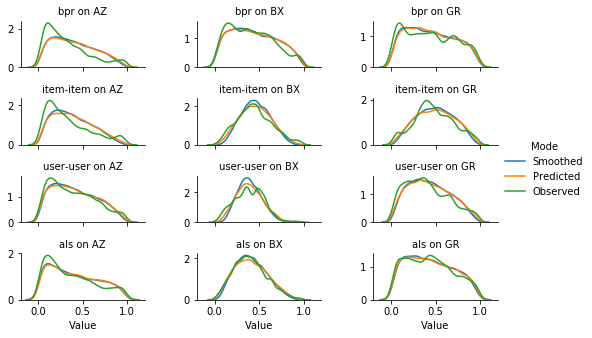

In [22]:
grid = sns.FacetGrid(col='Set', row='Algorithm', hue='Mode',
                     data=select_implicit(bias_data),
                     sharey=False, aspect=2, height=1.2)
grid.map(sns.kdeplot, 'Value', clip=(0,1)).add_legend().set_titles("{row_name} on {col_name}")
plt.savefig('figures/rec-implicit-dense.pdf')

And the **explicit** runs:

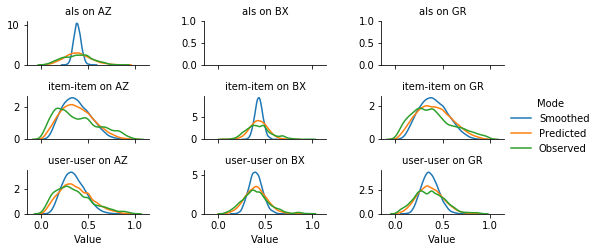

In [23]:
grid = sns.FacetGrid(col='Set', row='Algorithm', hue='Mode',
                     data=select_explicit(bias_data),
                     sharey=False, aspect=2, height=1.2)
grid.map(sns.kdeplot, 'Value', clip=(0,1)).add_legend().set_titles("{row_name} on {col_name}")
plt.savefig('figures/rec-explicit-dense.pdf')

## Examining Regression Parameters

In [24]:
params = pd.DataFrame({
    'Intercept': algo_samples('recB').mean(axis=1),
    'Slope': algo_samples('recS').mean(axis=1),
    'Variance': algo_samples('recV').mean(axis=1)
})
params.head()

Intercept     Slope  Variance
Set Algorithm                                   
AZ  als            -0.414955  0.100469  0.603840
    bpr-imp        -0.110768  0.770165  1.025784
    item-item      -0.335121  0.418237  0.851281
    item-item-imp  -0.224699  0.683277  1.002361
    user-user      -0.476950  0.338850  0.696759

In [25]:
param_samples = pd.DataFrame({
    'Intercept': algo_samples('recB').stack(),
    'Slope': algo_samples('recS').stack(),
    'Variance': algo_samples('recV').stack()
})
param_samples.head()

Intercept     Slope  Variance
Set Algorithm Sample                               
AZ  als       0       -0.448924  0.107905  0.575669
              1       -0.433161  0.093143  0.594322
              2       -0.443778  0.111127  0.580535
              3       -0.386323  0.092659  0.604916
              4       -0.422481  0.107835  0.624784

What are the **implicit** parameters?

In [26]:
select_implicit(params).pivot(index='Algorithm', columns='Set', values=['Intercept', 'Slope', 'Variance'])

Intercept                         Slope                      \
Set              AZ        BX        GR        AZ        BX        GR   
Algorithm                                                               
als       -0.041885 -0.108645 -0.049803  0.960454  0.780457  1.025921   
bpr       -0.110768  0.183296 -0.018421  0.770165  1.277556  1.082126   
item-item -0.224699  0.097499  0.179856  0.683277  0.682584  0.736844   
user-user -0.045549 -0.244654 -0.108745  0.786043  0.564131  0.858013   

           Variance                      
Set              AZ        BX        GR  
Algorithm                                
als        0.714139  0.416329  0.538058  
bpr        1.025784  0.636365  0.779331  
item-item  1.002361  0.690684  0.744868  
user-user  0.616849  0.547037  0.737842

In [27]:
imp_recB = select_implicit(algo_samples('recB')).set_index(['Set', 'Algorithm'])
imp_recS = select_implicit(algo_samples('recS')).set_index(['Set', 'Algorithm'])
imp_recV = select_implicit(algo_samples('recV')).set_index(['Set', 'Algorithm'])
imp_ds = imp_recB.index.levels[0]
imp_as = imp_recB.index.levels[1]

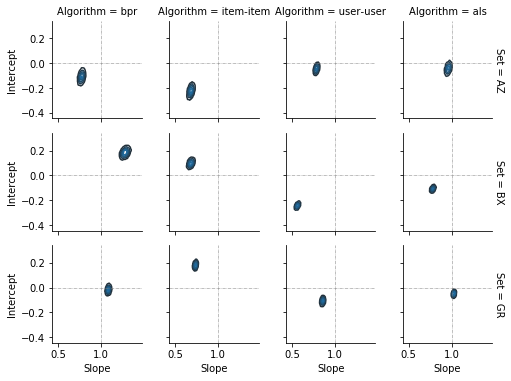

In [28]:
grid = sns.FacetGrid(col='Algorithm', row='Set', data=select_implicit(param_samples), margin_titles=True, height=1.8)
def _si_kde(*args, **kwargs):
    plt.axhline(0, 0, 1, ls='-.', lw=0.5, color='grey')
    plt.axvline(1, 0, 1, ls='-.', lw=0.5, color='grey')
    sns.kdeplot(*args, levels=5, **kwargs)
grid.map(_si_kde, 'Slope', 'Intercept')
plt.savefig('figures/reg-param-implicit.pdf')

What are the **explicit** parameters?

In [29]:
select_explicit(params).pivot(index='Algorithm', columns='Set', values=['Intercept', 'Slope', 'Variance'])

Intercept                         Slope                      \
Set              AZ        BX        GR        AZ        BX        GR   
Algorithm                                                               
als       -0.414955       NaN       NaN  0.100469       NaN       NaN   
item-item -0.335121 -0.215404 -0.317603  0.418237  0.151469  0.445734   
user-user -0.476950 -0.308696 -0.503888  0.338850  0.264338  0.260073   

           Variance                      
Set              AZ        BX        GR  
Algorithm                                
als        0.603840       NaN       NaN  
item-item  0.851281  0.516450  0.891118  
user-user  0.696759  0.535872  0.620585

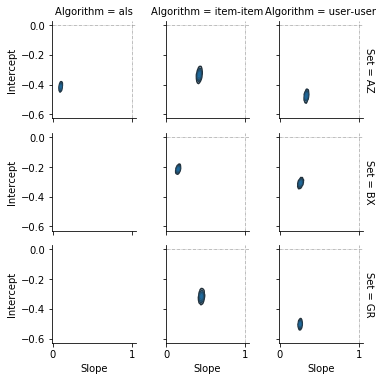

In [30]:
grid = sns.FacetGrid(col='Algorithm', row='Set', data=select_explicit(param_samples), margin_titles=True, height=1.8)
def _si_kde(*args, **kwargs):
    plt.axhline(0, 0, 1, ls='-.', lw=0.5, color='grey')
    plt.axvline(1, 0, 1, ls='-.', lw=0.5, color='grey')
    sns.kdeplot(*args, levels=5, **kwargs)
grid.map(_si_kde, 'Slope', 'Intercept')
plt.savefig('figures/reg-param-explicit.pdf')

## Plotting Regressions

Let's plot those regressions.

In [31]:
def plot_relations(points, params, size=(6, 8)):
    p_sets = points.index.levels[0]
    p_algos = points.index.levels[1]
    print(f'plotting {len(p_algos)} algorithms for {len(p_sets)} data sets',
          file=sys.stderr)
    fig, axes = plt.subplots(len(p_algos), len(p_sets), constrained_layout=True,
                             figsize=size)

    for c, s in enumerate(p_sets):
        axes[0, c].set_title(s)
        for r, a in enumerate(p_algos):
            if (s, a) in points.index:
                sns.scatterplot('ProfileBias', 'Bias', data=points.loc[(s,a), :],
                                alpha=0.2, ax=axes[r,c])
                sns.rugplot(points.loc[(s,a), 'Bias'], ax=axes[r, c], axis='y')
            if (s, a) in params.index:
                cx, cy = make_curve(params.loc[(s, a), 'Intercept'],
                                    params.loc[(s, a), 'Slope'])
                sns.lineplot(cx, cy, ax=axes[r, c], color='red')
            if c == 0:
                axes[r, 0].set_ylabel(a)
            if r < 3:
                axes[r, c].set_xlabel(None)

In [32]:
def make_curve(intercept, slope, res=0.005):
    x = np.arange(0, 1, res)
    y = expit(intercept + slope * logit(x))
    return (x, y)

We will start with **implicit** data:

In [33]:
imp_points = pd.merge(
    select_implicit(profiles)[['Set', 'user', 'ProfileBias']],
    select_implicit(rec_lists)[['Set', 'Algorithm', 'user', 'Bias']]
).set_index(['Set', 'Algorithm', 'user'])
imp_points.head()

ProfileBias     Bias
Set Algorithm user                       
AZ  bpr       34891          1.0  1.00000
    item-item 34891          1.0      NaN
    user-user 34891          1.0  1.00000
    als       34891          1.0  1.00000
    bpr       35841          1.0  0.76087

plotting 4 algorithms for 3 data sets
C:\Users\michaelekstrand\Anaconda3\envs\bfold\lib\site-packages\IPython\core\interactiveshell.py:2858: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
C:\Users\michaelekstrand\Anaconda3\envs\bfold\lib\site-packages\pandas\core\indexing.py:1418: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Users\michaelekstrand\Anaconda3\envs\bfold\lib\site-packages\IPython\core\interactiveshell.py:2858: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
C:\Users\michaelekstrand\Anaconda3\envs\bfold\lib\site-packages\pandas\core\indexing.py:1418: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


C:\Users\michaelekstrand\Anaconda3\envs\bfold\lib\site-packages\IPython\core\interactiveshell.py:2858: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
C:\Users\michaelekstrand\Anaconda3\envs\bfold\lib\site-packages\pandas\core\indexing.py:1418: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Users\michaelekstrand\Anaconda3\envs\bfold\lib\site-packages\IPython\core\interactiveshell.py:2858: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
C:\Users\michaelekstrand\Anaconda3\envs\bfold\lib\site-packages\pandas\core\indexing.py:1418: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Users\michaelekstrand\Anaconda3\envs\bfold\lib\site-packages\IPython\core\interactiveshell.py:2858: PerformanceWarning: indexing past lexsort depth

C:\Users\michaelekstrand\Anaconda3\envs\bfold\lib\site-packages\IPython\core\interactiveshell.py:2858: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
C:\Users\michaelekstrand\Anaconda3\envs\bfold\lib\site-packages\pandas\core\indexing.py:1418: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Users\michaelekstrand\Anaconda3\envs\bfold\lib\site-packages\IPython\core\interactiveshell.py:2858: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
C:\Users\michaelekstrand\Anaconda3\envs\bfold\lib\site-packages\pandas\core\indexing.py:1418: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Users\michaelekstrand\Anaconda3\envs\bfold\lib\site-packages\IPython\core\interactiveshell.py:2858: PerformanceWarning: indexing past lexsort depth

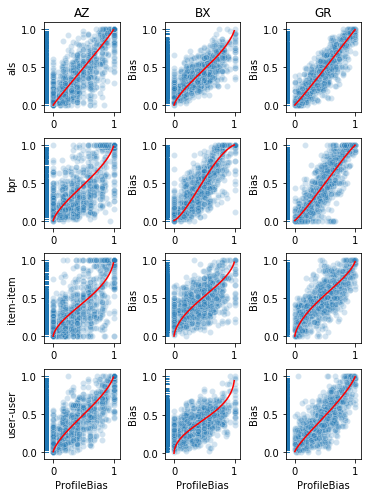

In [34]:
plot_relations(imp_points, select_implicit(params).set_index(['Set', 'Algorithm']), (5,6.8))
plt.savefig('figures/reg-scatter-imp.pdf')

plotting 4 algorithms for 3 data sets
C:\Users\michaelekstrand\Anaconda3\envs\bfold\lib\site-packages\IPython\core\interactiveshell.py:2858: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
C:\Users\michaelekstrand\Anaconda3\envs\bfold\lib\site-packages\pandas\core\indexing.py:1418: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Users\michaelekstrand\Anaconda3\envs\bfold\lib\site-packages\IPython\core\interactiveshell.py:2858: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
C:\Users\michaelekstrand\Anaconda3\envs\bfold\lib\site-packages\pandas\core\indexing.py:1418: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


C:\Users\michaelekstrand\Anaconda3\envs\bfold\lib\site-packages\IPython\core\interactiveshell.py:2858: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
C:\Users\michaelekstrand\Anaconda3\envs\bfold\lib\site-packages\pandas\core\indexing.py:1418: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Users\michaelekstrand\Anaconda3\envs\bfold\lib\site-packages\IPython\core\interactiveshell.py:2858: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
C:\Users\michaelekstrand\Anaconda3\envs\bfold\lib\site-packages\pandas\core\indexing.py:1418: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Users\michaelekstrand\Anaconda3\envs\bfold\lib\site-packages\IPython\core\interactiveshell.py:2858: PerformanceWarning: indexing past lexsort depth

C:\Users\michaelekstrand\Anaconda3\envs\bfold\lib\site-packages\pandas\core\indexing.py:1418: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Users\michaelekstrand\Anaconda3\envs\bfold\lib\site-packages\IPython\core\interactiveshell.py:2858: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
C:\Users\michaelekstrand\Anaconda3\envs\bfold\lib\site-packages\pandas\core\indexing.py:1418: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Users\michaelekstrand\Anaconda3\envs\bfold\lib\site-packages\IPython\core\interactiveshell.py:2858: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
C:\Users\michaelekstrand\Anaconda3\envs\bfold\lib\site-packages\pandas\core\indexing.py:1418: PerformanceWarning: indexing past lexsort depth may impa

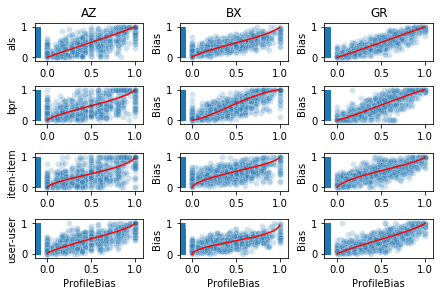

In [35]:
plot_relations(imp_points, select_implicit(params).set_index(['Set', 'Algorithm']), size=(6, 4))

And the **explicit** data:

In [36]:
exp_points = pd.merge(
    select_explicit(profiles)[['Set', 'user', 'ProfileBias']],
    select_explicit(rec_lists)[['Set', 'Algorithm', 'user', 'Bias']]
).set_index(['Set', 'Algorithm', 'user'])
exp_points.head()

ProfileBias      Bias
Set Algorithm user                        
AZ  als       34891          1.0  0.428571
    item-item 34891          1.0  0.750000
    user-user 34891          1.0  0.555556
    als       35841          1.0  0.750000
    item-item 35841          1.0  0.666667

plotting 3 algorithms for 3 data sets
C:\Users\michaelekstrand\Anaconda3\envs\bfold\lib\site-packages\IPython\core\interactiveshell.py:2858: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
C:\Users\michaelekstrand\Anaconda3\envs\bfold\lib\site-packages\pandas\core\indexing.py:1418: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Users\michaelekstrand\Anaconda3\envs\bfold\lib\site-packages\IPython\core\interactiveshell.py:2858: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
C:\Users\michaelekstrand\Anaconda3\envs\bfold\lib\site-packages\pandas\core\indexing.py:1418: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Users\michaelekstrand\Anaconda3\envs\bfold\lib\site-packages\IPython\core\interactiveshell.py:2858: Performan

C:\Users\michaelekstrand\Anaconda3\envs\bfold\lib\site-packages\pandas\core\indexing.py:1418: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Users\michaelekstrand\Anaconda3\envs\bfold\lib\site-packages\IPython\core\interactiveshell.py:2858: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
C:\Users\michaelekstrand\Anaconda3\envs\bfold\lib\site-packages\pandas\core\indexing.py:1418: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
C:\Users\michaelekstrand\Anaconda3\envs\bfold\lib\site-packages\IPython\core\interactiveshell.py:2858: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
C:\Users\michaelekstrand\Anaconda3\envs\bfold\lib\site-packages\pandas\core\indexing.py:1418: PerformanceWarning: indexing past lexsort depth may impa

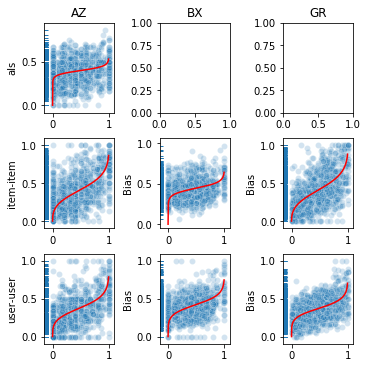

In [37]:
plot_relations(exp_points, select_explicit(params).set_index(['Set', 'Algorithm']), (5,5))
plt.savefig('figures/reg-scatter-exp.pdf')

## Checking Model Assumptions

Like good modelers, we are going to check our assumptions.

Let's start with normality of residuals in our linear model.

In [38]:
residuals = list_samples('noiseR', True).reset_index(name='resid')
residuals.head()

,Set,Algorithm,user,resid
0,AZ,als,34891,-0.150554
1,AZ,als,35841,0.863373
2,AZ,als,39018,-1.450149
3,AZ,als,52563,-0.305358
4,AZ,als,60825,0.992210


In [39]:
def qqplot(xs, **kwargs):
    th, ob = stats.probplot(xs, fit=False)
    plt.scatter(th, ob, **kwargs)

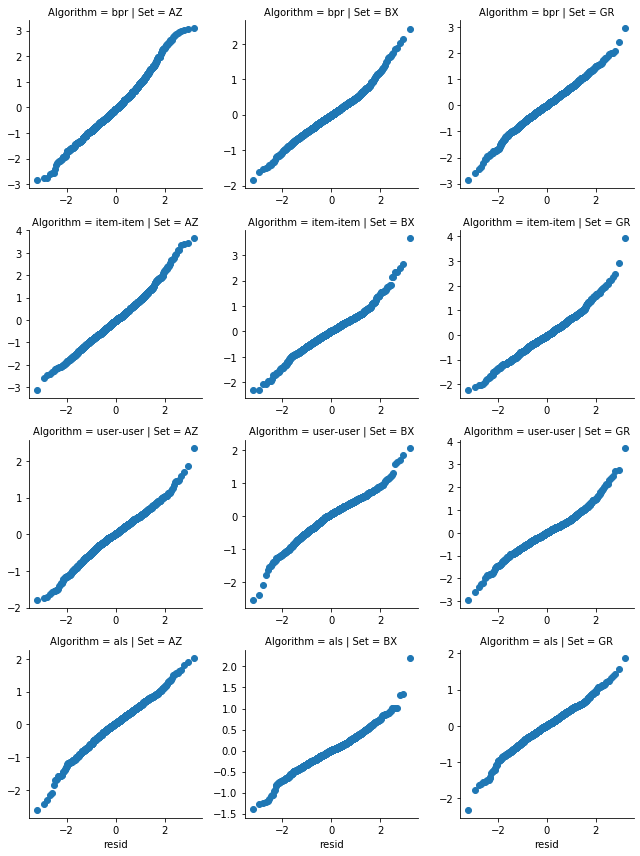

In [40]:
grid = sns.FacetGrid(row='Algorithm', col='Set', data=select_implicit(residuals), sharex=False, sharey=False)
grid.map(qqplot, 'resid')

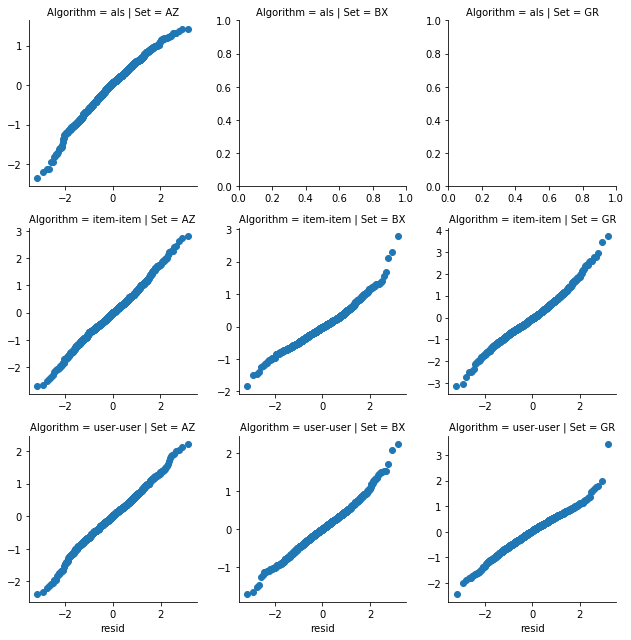

In [41]:
grid = sns.FacetGrid(row='Algorithm', col='Set', data=select_explicit(residuals), sharex=False, sharey=False)
grid.map(qqplot, 'resid')

Homoskedasticity of errors?

In [42]:
predicted = list_samples('rbias', True).reset_index(name='pred')
predicted = pd.merge(predicted, residuals)
predicted.head()

,Set,Algorithm,user,pred,resid
0,AZ,als,34891,-0.100760,-0.150554
1,AZ,als,35841,-0.170226,0.863373
2,AZ,als,39018,-0.564754,-1.450149
3,AZ,als,52563,-0.062367,-0.305358
4,AZ,als,60825,-0.550378,0.992210


In [43]:
def rscatter(x, y, **kwargs):
    sns.scatterplot(x, y, **kwargs)
    sns.rugplot(x, axis='x')
    sns.rugplot(y, axis='y')

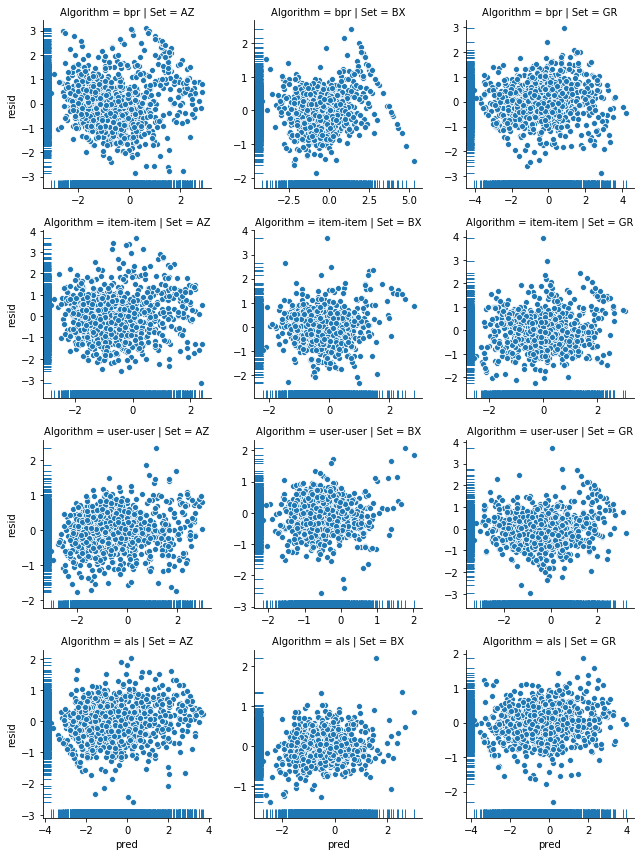

In [44]:
grid = sns.FacetGrid(row='Algorithm', col='Set', data=select_implicit(predicted), sharex=False, sharey=False)
grid.map(rscatter, 'pred', 'resid')

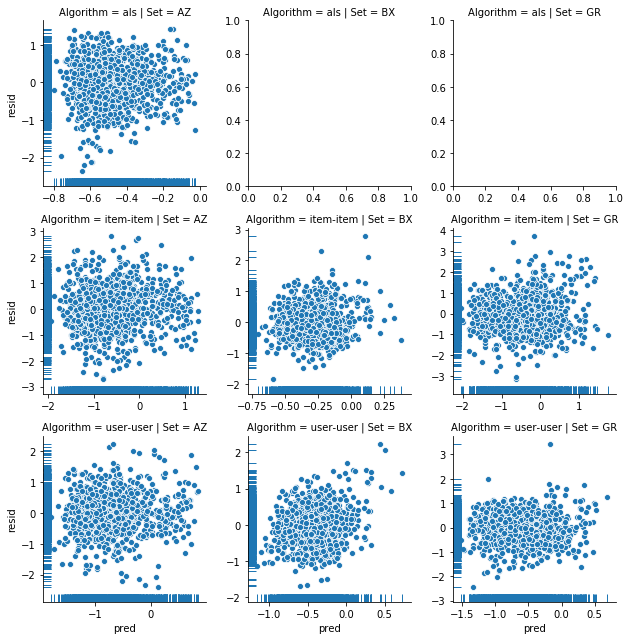

In [45]:
grid = sns.FacetGrid(row='Algorithm', col='Set', data=select_explicit(predicted), sharex=False, sharey=False)
grid.map(rscatter, 'pred', 'resid')